In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
file_path = 'Reconstructed_Data_With_Original_Columns_And_Param_Names.csv'
data = pd.read_csv(file_path)

# Convert data types to reduce memory usage by changing float64 to float32 and int64 to int32
data = data.astype({col: 'float32' for col in data.select_dtypes(include=['float64']).columns})
data = data.astype({col: 'int32' for col in data.select_dtypes(include(['int64']).columns})

# Check data structure and preview the first few rows
print(data.info())
print(data.head())

# Define the geospatial and temporal feature columns, and the target variables
geospatial_columns = ['easting', 'northing']
time_columns = ['year', 'month', 'day']
target_columns = ['aluminium', 'cadmium', 'chromium', 'copper', 'iron', 
                  'iron, dissolved', 'lead', 'mercury', 'nickel', 
                  'ph', 'temperature of water', 'zinc']

# Separate the features (X) and target variables (y)
X = data[geospatial_columns + time_columns]
y = data[target_columns]

# Standardize the geospatial features for normalization
scaler = StandardScaler()
X[geospatial_columns] = scaler.fit_transform(X[geospatial_columns])

# Standardize the temporal features
X[time_columns] = scaler.fit_transform(X[time_columns])

# Check the standardized feature set
print(X.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283184 entries, 0 to 283183
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   station_number        283184 non-null  object 
 1   sampling_datetime     283184 non-null  object 
 2   aluminium             283184 non-null  float32
 3   cadmium               283184 non-null  float32
 4   chromium              283184 non-null  float32
 5   copper                283184 non-null  float32
 6   iron                  283184 non-null  float32
 7   iron, dissolved       283184 non-null  float32
 8   lead                  283184 non-null  float32
 9   mercury               283184 non-null  float32
 10  nickel                283184 non-null  float32
 11  ph                    283184 non-null  float32
 12  temperature of water  283184 non-null  float32
 13  zinc                  283184 non-null  float32
 14  easting               283184 non-null  float32
 15  

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_12376\2139341375.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[geospatial_columns] = scaler.fit_transform(X[geospatial_columns])
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_12376\2139341375.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[time_columns] = scaler.fit_transform(X[time_columns])


In [2]:
# Set the number of time steps (look-back period) for LSTM/GRU models
n_steps = 10

# Function to create sequences of data for LSTM/GRU models.
# It constructs input sequences of length 'n_steps' and corresponding target values.
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(n_steps, len(X)):
        Xs.append(X[i-n_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Generate sequences of features and target variables
X_lstm, y_lstm = create_sequences(X.values, y.values, n_steps)

# Split the sequences into training and validation sets (80% training, 20% validation)
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Print the shapes of the resulting training and validation sets
print(X_train_lstm.shape, y_train_lstm.shape)



(226539, 10, 5) (226539, 12)


In [27]:
# For Random Forest and XGBoost models, flatten the 3D time-series data into 2D format
# Random Forest and XGBoost models require 2D data instead of 3D like LSTM/GRU

# Reshape the LSTM/GRU 3D training and validation data into 2D
X_train_rf = X_train_lstm.reshape(X_train_lstm.shape[0], -1)
X_val_rf = X_val_lstm.reshape(X_val_lstm.shape[0], -1)

# Print the shapes of the resulting 2D training and validation data for Random Forest and XGBoost
print(X_train_rf.shape, X_val_rf.shape)




(226539, 50) (56635, 50)


In [4]:
# Train an LSTM model using TensorFlow and Keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# Function to build the LSTM model
def build_lstm_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(LSTM(50, activation='relu'))  # Second LSTM layer
    model.add(Dense(output_shape))  # Output layer
    model.compile(optimizer='adam', loss='mse')  # Compile model with Adam optimizer and MSE loss
    return model

# Build and train the LSTM model
lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]), y_train_lstm.shape[1])
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm), epochs=20, batch_size=32, verbose=2)

# Save the trained LSTM model
lstm_model.save('lstm_model.h5')



E:\CodeSoft\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
7080/7080 - 132s - 19ms/step - loss: 0.0389 - val_loss: 0.0336
Epoch 2/20
7080/7080 - 125s - 18ms/step - loss: 0.0307 - val_loss: 0.0286
Epoch 3/20
7080/7080 - 126s - 18ms/step - loss: 0.0269 - val_loss: 0.0257
Epoch 4/20
7080/7080 - 126s - 18ms/step - loss: 0.0240 - val_loss: 0.0243
Epoch 5/20
7080/7080 - 127s - 18ms/step - loss: 0.0219 - val_loss: 0.0215
Epoch 6/20
7080/7080 - 126s - 18ms/step - loss: 0.0203 - val_loss: 0.0203
Epoch 7/20
7080/7080 - 126s - 18ms/step - loss: 0.0191 - val_loss: 0.0194
Epoch 8/20
7080/7080 - 126s - 18ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 9/20
7080/7080 - 127s - 18ms/step - loss: 0.0173 - val_loss: 0.0172
Epoch 10/20
7080/7080 - 127s - 18ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 11/20
7080/7080 - 127s - 18ms/step - loss: 0.0159 - val_loss: 0.0166
Epoch 12/20
7080/7080 - 127s - 18ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 13/20
7080/7080 - 127s - 18ms/step - loss: 0.0149 - val_loss: 0.0157
Epoch 14/20
7080/7080 - 126s - 18m

In [5]:
lstm_model.save('lstm_model.keras')

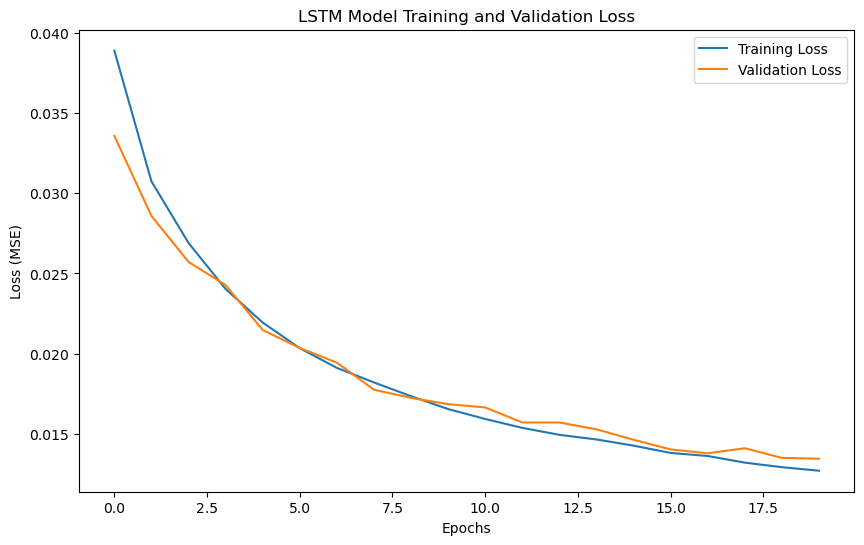

In [60]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [6]:
# Import GRU layer from TensorFlow
from tensorflow.keras.layers import GRU

# Function to build a GRU-based neural network model
# This function creates a sequential model with two GRU layers and one Dense output layer
def build_gru_model(input_shape, output_shape):
    model = Sequential()
    model.add(GRU(100, activation='relu', return_sequences=True, input_shape=input_shape))  # First GRU layer
    model.add(GRU(50, activation='relu'))  # Second GRU layer without returning sequences
    model.add(Dense(output_shape))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mse')  # Compile with Adam optimizer and MSE as the loss function
    return model

# Initialize and train the GRU model on the training dataset
gru_model = build_gru_model((X_train_lstm.shape[1], X_train_lstm.shape[2]), y_train_lstm.shape[1])
history_gru = gru_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm), epochs=20, batch_size=32, verbose=2)

# Save the trained model to a file
gru_model.save('gru_model.keras')



Epoch 1/20
7080/7080 - 154s - 22ms/step - loss: 0.0394 - val_loss: 0.0346
Epoch 2/20
7080/7080 - 146s - 21ms/step - loss: 0.0318 - val_loss: 0.0298
Epoch 3/20
7080/7080 - 147s - 21ms/step - loss: 0.0282 - val_loss: 0.0268
Epoch 4/20
7080/7080 - 147s - 21ms/step - loss: 0.0259 - val_loss: 0.0252
Epoch 5/20
7080/7080 - 147s - 21ms/step - loss: 0.0239 - val_loss: 0.0236
Epoch 6/20
7080/7080 - 147s - 21ms/step - loss: 0.0225 - val_loss: 0.0232
Epoch 7/20
7080/7080 - 147s - 21ms/step - loss: 0.0213 - val_loss: 0.0214
Epoch 8/20
7080/7080 - 147s - 21ms/step - loss: 0.0203 - val_loss: 0.0209
Epoch 9/20
7080/7080 - 147s - 21ms/step - loss: 0.0195 - val_loss: 0.0195
Epoch 10/20
7080/7080 - 147s - 21ms/step - loss: 0.0188 - val_loss: 0.0191
Epoch 11/20
7080/7080 - 147s - 21ms/step - loss: 0.0181 - val_loss: 0.0191
Epoch 12/20
7080/7080 - 147s - 21ms/step - loss: 0.0175 - val_loss: 0.0188
Epoch 13/20
7080/7080 - 146s - 21ms/step - loss: 0.0171 - val_loss: 0.0177
Epoch 14/20
7080/7080 - 147s - 21m

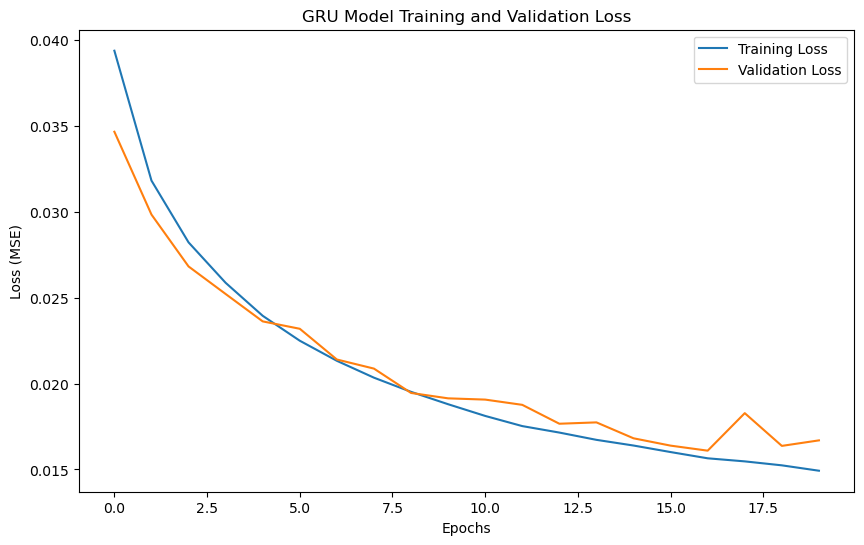

In [59]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Train a Random Forest model
# A RandomForestRegressor is used with 100 trees and a fixed random state for reproducibility
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_lstm)

# Predict on the validation set and calculate the Mean Squared Error (MSE)
y_val_pred_rf = rf_model.predict(X_val_rf)
rf_val_mse = mean_squared_error(y_val_lstm, y_val_pred_rf)

# Save the trained Random Forest model to a file using joblib
joblib.dump(rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

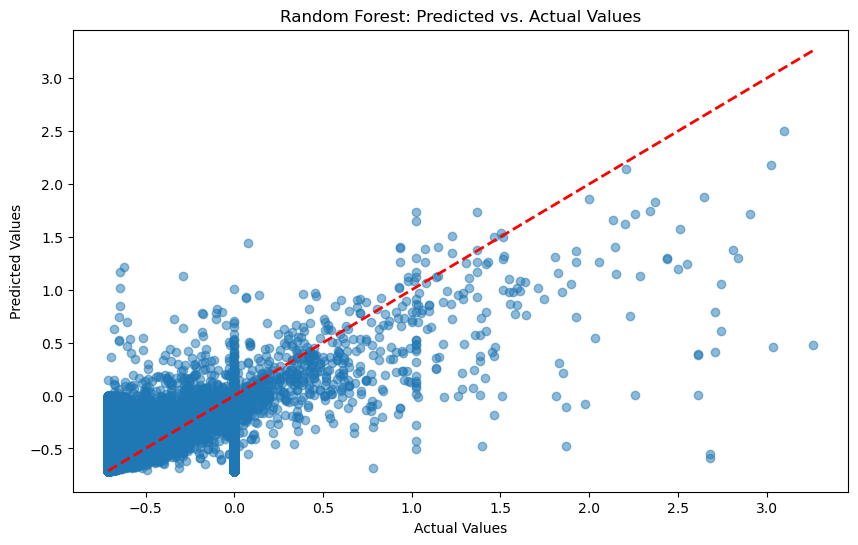

In [58]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val_lstm, y_val_pred_rf, alpha=0.5)
plt.plot([y_val_lstm.min(), y_val_lstm.max()], [y_val_lstm.min(), y_val_lstm.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Predicted vs. Actual Values')
plt.show()


In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib

# Flatten 3D LSTM data into 2D format for use with XGBoost
X_train_rf = X_train_lstm.reshape(X_train_lstm.shape[0], -1)
X_val_rf = X_val_lstm.reshape(X_val_lstm.shape[0], -1)

# Verify that the data shapes are correct after flattening
print(f"X_train shape: {X_train_rf.shape}")
print(f"X_val shape: {X_val_rf.shape}")

# Train an XGBoost regression model with 100 estimators
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_rf, y_train_lstm)

# Predict on the validation set and compute the Mean Squared Error (MSE)
y_val_pred_xgb = xgb_model.predict(X_val_rf)
xgb_val_mse = mean_squared_error(y_val_lstm, y_val_pred_xgb)

# Save the trained XGBoost model to a JSON file
xgb_model.save_model('xgboost_model.json')

# Print the MSE on the validation set
print(f"XGBoost Validation MSE: {xgb_val_mse:.4f}")



X_train shape: (226539, 50)
X_val shape: (56635, 50)
XGBoost Validation MSE: 0.0100


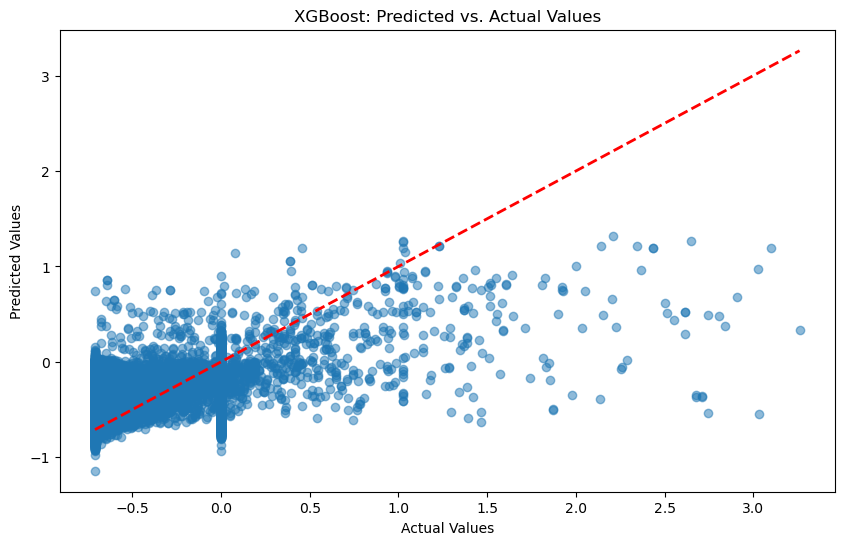

In [61]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val_lstm, y_val_pred_xgb, alpha=0.5)
plt.plot([y_val_lstm.min(), y_val_lstm.max()], [y_val_lstm.min(), y_val_lstm.max()], '--r', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost: Predicted vs. Actual Values')
plt.show()


LSTM Validation Loss: 0.0134
GRU Validation Loss: 0.0167
Random Forest Validation MSE: 0.0054
XGBoost Validation MSE: 0.0100


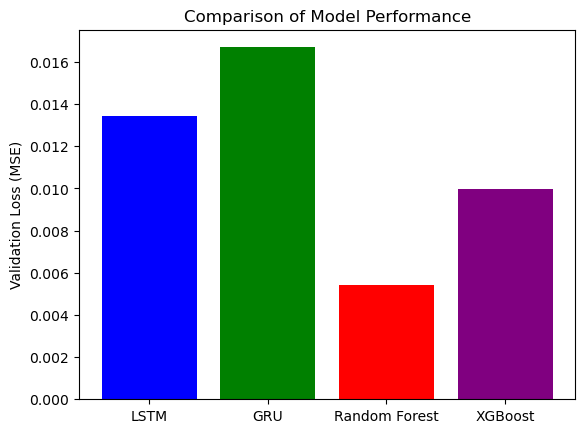

The best model is: Random Forest with a Validation Loss of: 0.0054


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Compare the validation losses (MSE) of all models
print(f"LSTM Validation Loss: {history_lstm.history['val_loss'][-1]:.4f}")
print(f"GRU Validation Loss: {history_gru.history['val_loss'][-1]:.4f}")
print(f"Random Forest Validation MSE: {rf_val_mse:.4f}")
print(f"XGBoost Validation MSE: {xgb_val_mse:.4f}")

# Store the model names and their corresponding validation losses
models = ['LSTM', 'GRU', 'Random Forest', 'XGBoost']
val_losses = [history_lstm.history['val_loss'][-1], history_gru.history['val_loss'][-1], rf_val_mse, xgb_val_mse]

# Create a bar chart to visualize the validation losses for each model
plt.bar(models, val_losses, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Validation Loss (MSE)')
plt.title('Comparison of Model Performance')
plt.show()

# Identify the best-performing model based on the lowest validation loss
best_model_index = np.argmin(val_losses)
best_model_name = models[best_model_index]
best_val_loss = val_losses[best_model_index]

# Print the name of the best model and its corresponding validation loss
print(f"The best model is: {best_model_name} with a Validation Loss of: {best_val_loss:.4f}")




In [14]:
import joblib

# Assuming the Random Forest model is the best
joblib.dump(rf_model, 'best_model_random_forest.pkl')


['best_model_random_forest.pkl']

In [15]:
import pandas as pd

# Load the original dataset
df = pd.read_csv('Reconstructed_Data_With_Original_Columns_And_Param_Names.csv')

# Randomly select 20 unique geographical locations (easting and northing)
selected_locations = df[['easting', 'northing']].drop_duplicates().sample(20)

# Alternatively, locations can be manually specified if needed
# selected_locations = pd.DataFrame({
#     'easting': [300000, 400000, ..., 320000],
#     'northing': [500000, 600000, ..., 520000]
# })

# Display the selected locations
print(selected_locations)



         easting  northing
261480  258103.0  207837.0
116838  276080.0  371700.0
12157   224889.0  207923.0
28856   221135.0  242546.0
224870  316100.0  169700.0
155109  180609.0  224309.0
122098  252680.0  382560.0
248800  337672.0  358383.0
30311   209770.0  238941.0
217021  313530.0  238120.0
202847  292828.0  264597.0
31350   226617.0  251433.0
37637   255666.0  227127.0
146273  310780.0  306990.0
209937  308366.0  265010.0
105015  260780.0  368610.0
136296  259431.0  197032.0
46198   246891.0  261030.0
245296  334880.0  355780.0
234362  290406.0  180250.0


In [16]:
import numpy as np

# Define the temporal features for 2024 (January to December)
months = np.arange(1, 13)
years = np.array([2024] * 12)

# Create a list to hold all data entries
data_list = []

# Iterate over each selected location and create data entries for each month of 2024
for _, row in selected_locations.iterrows():
    easting = row['easting']
    northing = row['northing']
    
    for month in months:
        data_list.append([easting, northing, 2024, month, 1])  # Assuming 'day' is not used
    
# Convert the list to a DataFrame
new_data = pd.DataFrame(data_list, columns=['easting', 'northing', 'year', 'month', 'day'])

print(new_data)


      easting  northing  year  month  day
0    258103.0  207837.0  2024      1    1
1    258103.0  207837.0  2024      2    1
2    258103.0  207837.0  2024      3    1
3    258103.0  207837.0  2024      4    1
4    258103.0  207837.0  2024      5    1
..        ...       ...   ...    ...  ...
235  290406.0  180250.0  2024      8    1
236  290406.0  180250.0  2024      9    1
237  290406.0  180250.0  2024     10    1
238  290406.0  180250.0  2024     11    1
239  290406.0  180250.0  2024     12    1

[240 rows x 5 columns]


  station_number    sampling_datetime  aluminium   cadmium  chromium  \
0      S00062260  2000-01-14 12:15:00        0.0 -0.710545 -0.710393   
1      S00062260  2000-01-14 12:15:00        0.0 -0.710545 -0.710393   
2      S00062260  2000-01-14 12:15:00        0.0 -0.710545 -0.710393   
3      S00062260  2000-02-10 12:30:00        0.0 -0.710506 -0.710269   
4      S00062260  2000-02-10 12:30:00        0.0 -0.710506 -0.710269   

     copper  iron  iron, dissolved      lead  mercury  ...  \
0 -0.703043   0.0              0.0 -0.708723      0.0  ...   
1 -0.703043   0.0              0.0 -0.708723      0.0  ...   
2 -0.703043   0.0              0.0 -0.708723      0.0  ...   
3 -0.699169   0.0              0.0 -0.707815      0.0  ...   
4 -0.699169   0.0              0.0 -0.707815      0.0  ...   

             unit_name  year  month  day  station_type_encoded  method_name  \
0  microgram per litre  2000      1   14                    23            4   
1               scalar  2000      1 

E:\CodeSoft\Anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
          LSTM         GRU
0    17.397903  -32.329037
1   -96.202393   80.907379
2  -230.239288   -2.005309
3  -109.430031   20.481567
4    31.344648 -176.459473
..         ...         ...
91  -14.663859   -6.868776
92 -303.113586   29.404657
93   75.984993    9.363979
94   84.903671  134.180954
95 -202.942261   25.666735

[96 rows x 2 columns]
Predictions saved to 'model_predictions.csv'


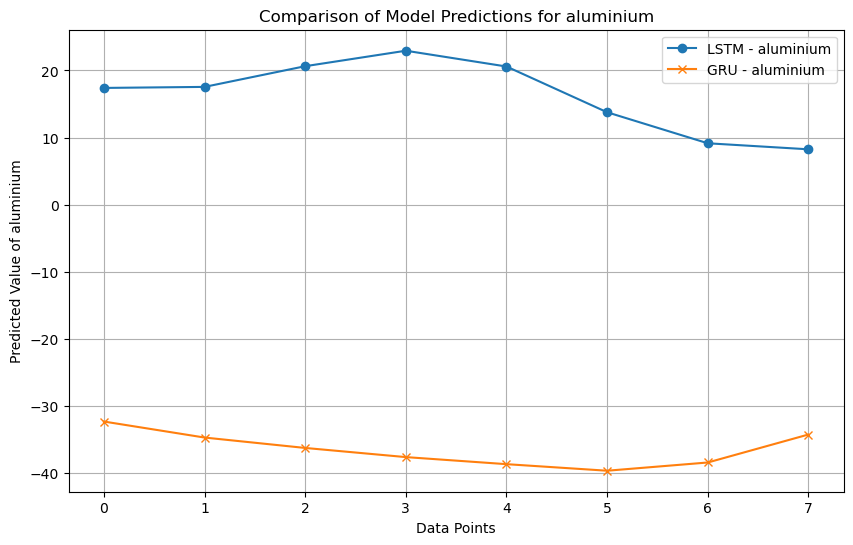

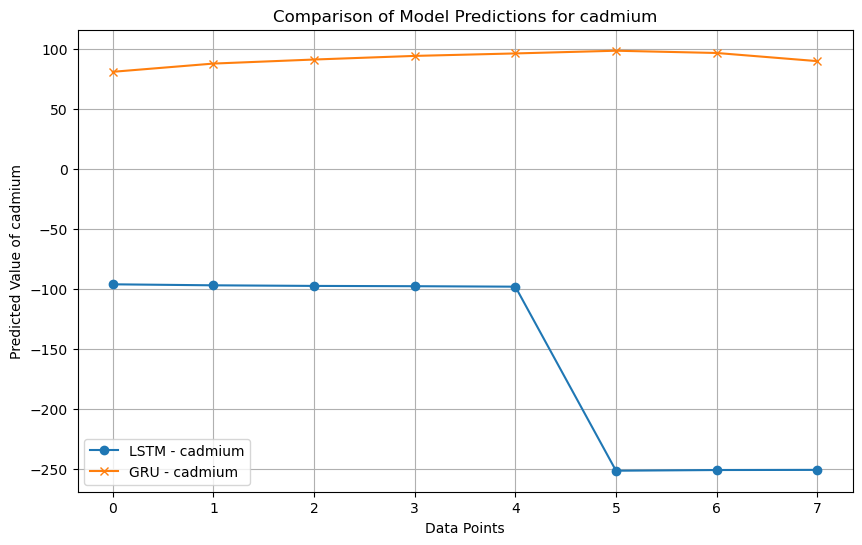

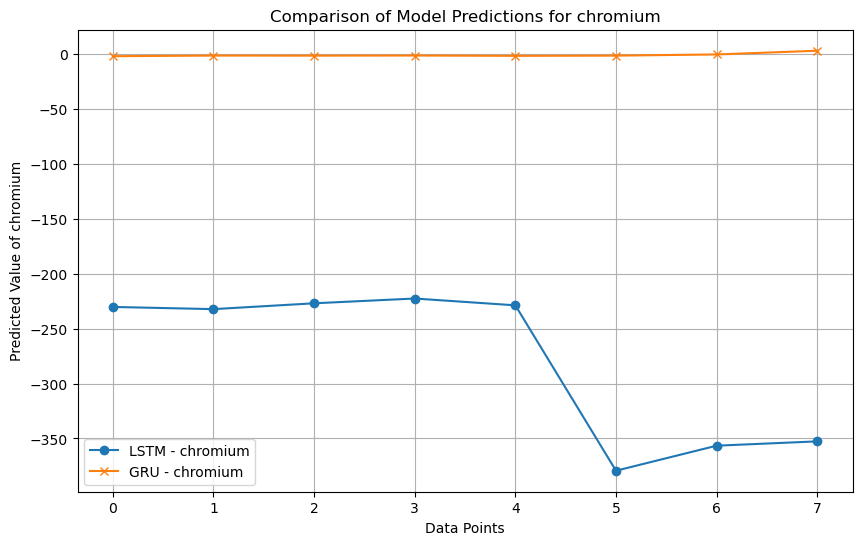

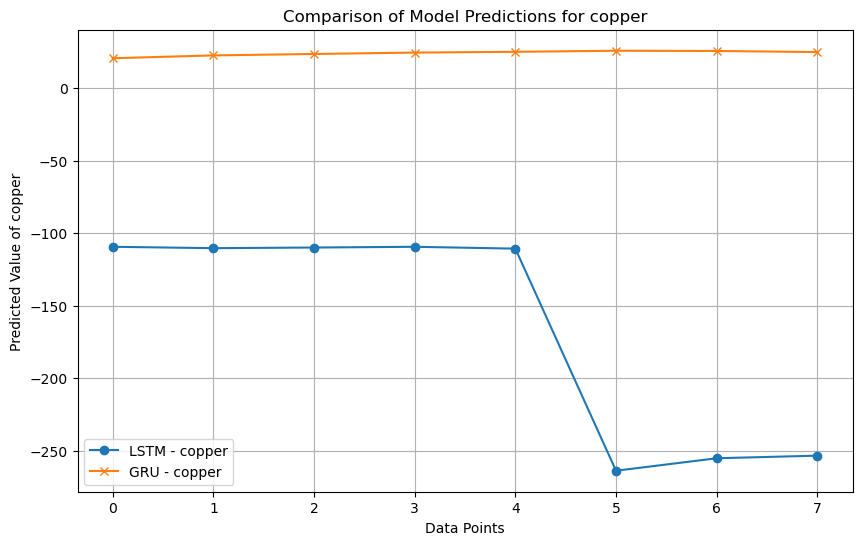

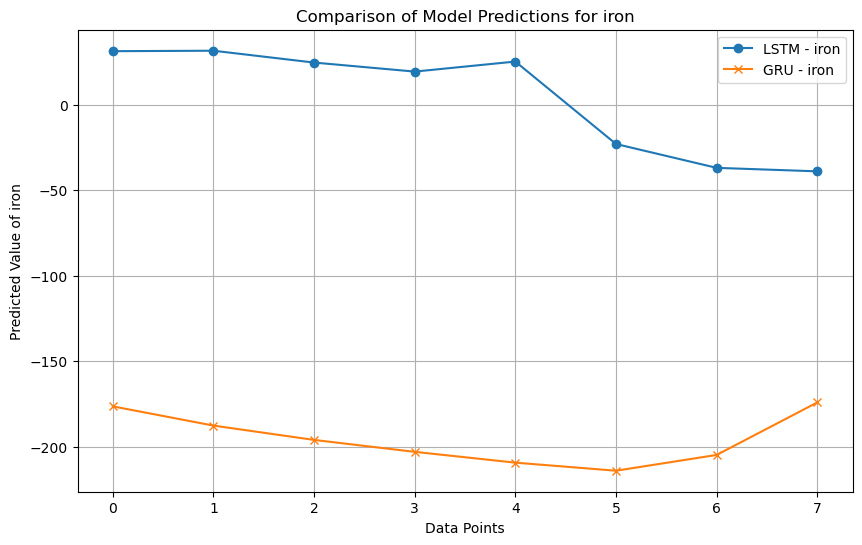

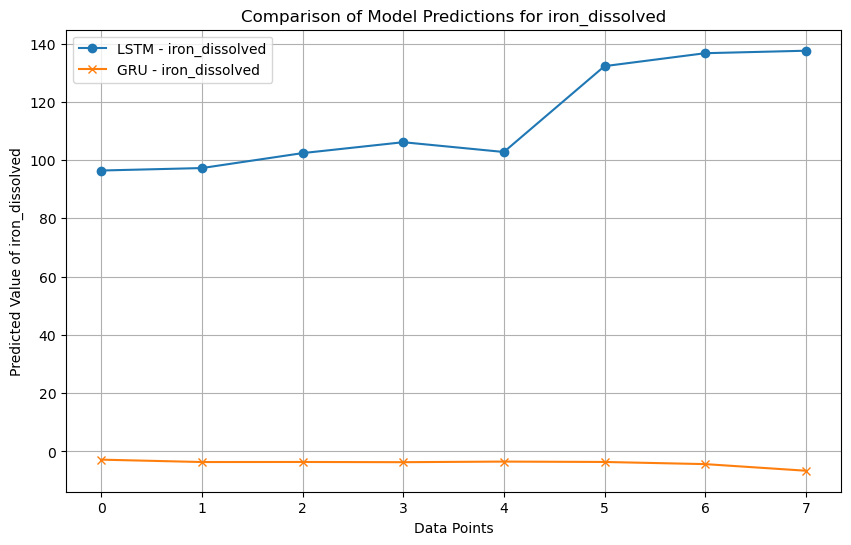

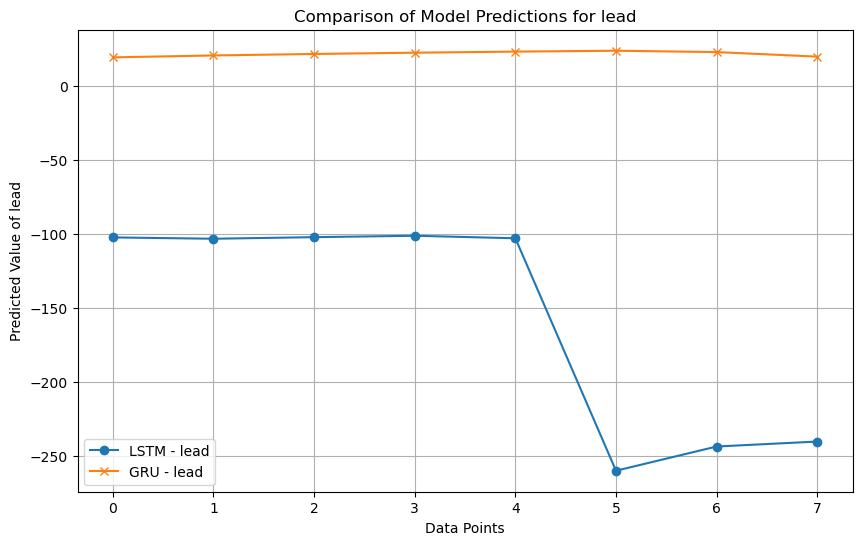

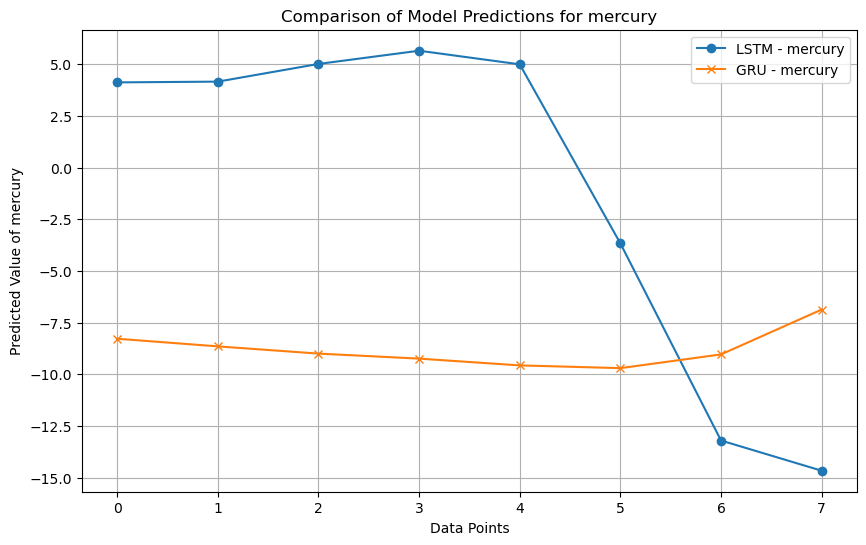

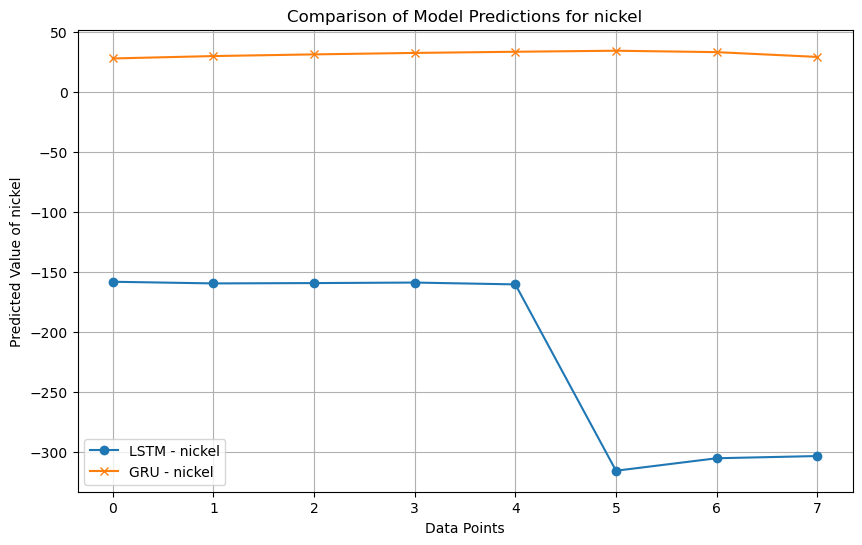

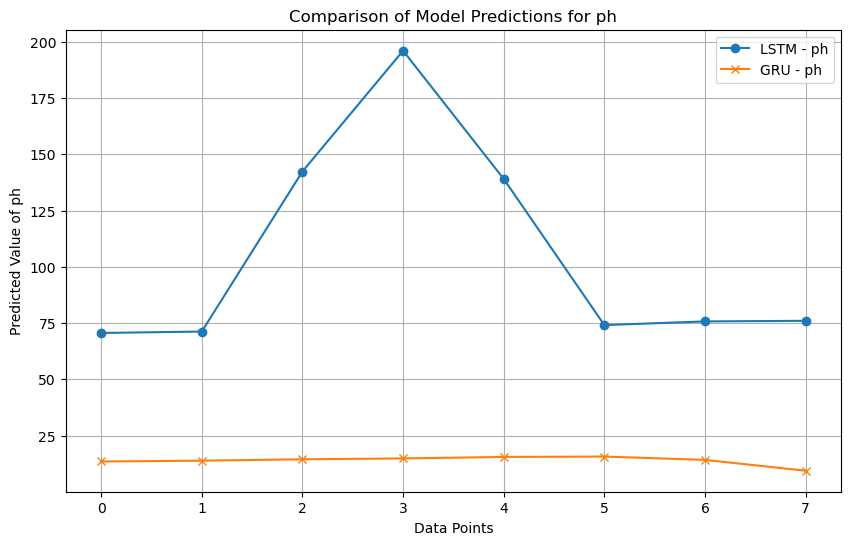

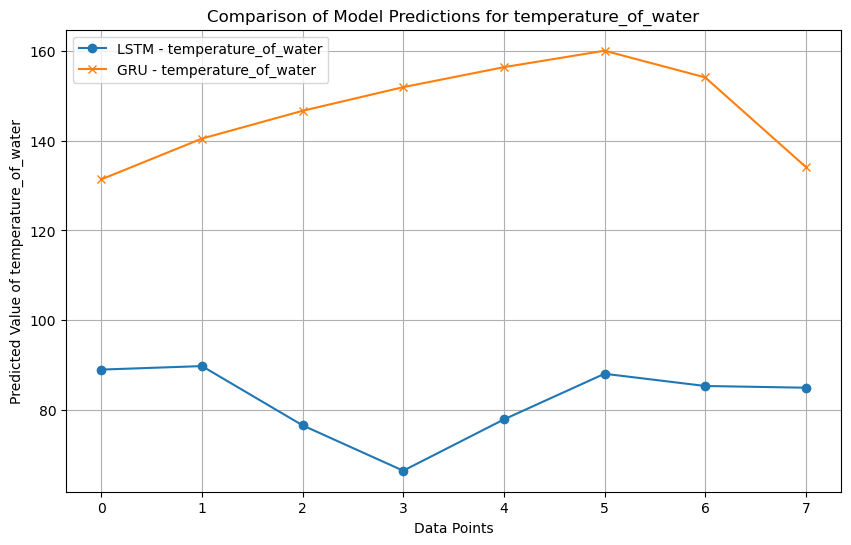

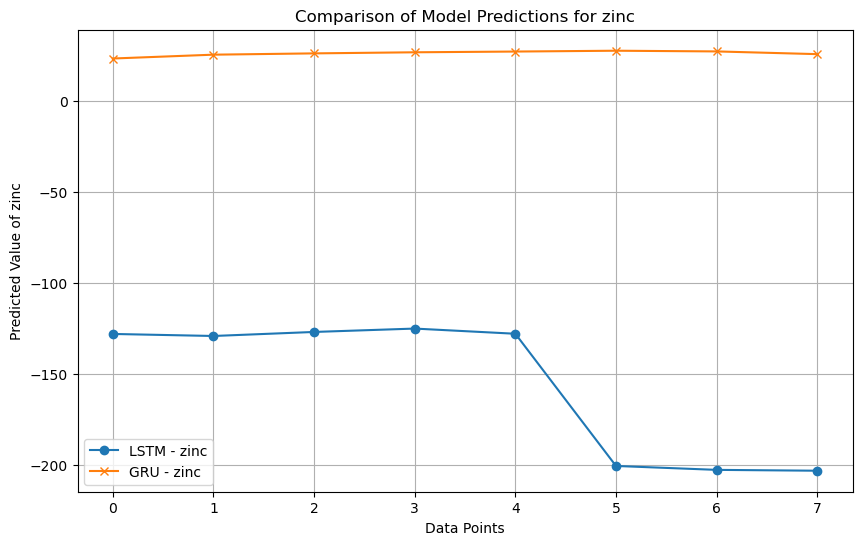

In [29]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from tensorflow.keras.models import load_model

# Step 1: Load the training data and fit the StandardScaler
training_data = pd.read_csv('Reconstructed_Data_With_Original_Columns_And_Param_Names.csv')

# Ensure that the training data contains the 'easting' and 'northing' columns
print(training_data.head())

# Fit the StandardScaler on the geographical columns
scaler = StandardScaler()
scaler.fit(training_data[['easting', 'northing']])

# Step 2: Prepare the new data for prediction
location_data = pd.DataFrame({
    'easting': [258103.0, 258103.0, 258103.0, 258103.0, 258103.0, 290406.0, 290406.0, 290406.0, 290406.0, 290406.0],
    'northing': [207837.0, 207837.0, 207837.0, 207837.0, 207837.0, 180250.0, 180250.0, 180250.0, 180250.0, 180250.0],
    'year': [2024] * 10,
    'month': [1, 2, 3, 4, 5, 8, 9, 10, 11, 12],
    'day': [1] * 10,
    # Add other relevant features if necessary
})

# Standardize the geographical data
location_data[['easting', 'northing']] = scaler.transform(location_data[['easting', 'northing']])

# Step 3: Prepare the data for each model
# For LSTM/GRU - assuming a sequence length of 3 months
sequence_length = 3  # Adjust this to match your model's training setup
X_lstm = []
for i in range(len(location_data) - sequence_length + 1):
    X_lstm.append(location_data.iloc[i:i+sequence_length].values)
X_lstm = np.array(X_lstm)

# Flatten the 3D LSTM data into 2D for Random Forest and XGBoost
X_rf = X_lstm.reshape(X_lstm.shape[0], -1)

# Step 4: Load the models and make predictions
# Load the RandomForest model
rf_model = joblib.load('best_model_random_forest.pkl')

# Load the XGBoost model
#xgb_model = xgb.XGBRegressor()
#xgb_model.load_model('xgboost_model.json')

# Load the LSTM and GRU models using Keras' load_model function
lstm_model = load_model('lstm_model.keras')
gru_model = load_model('gru_model.keras')

# Predict with each model
#predictions_rf = rf_model.predict(X_rf)
#predictions_xgb = xgb_model.predict(X_rf)
predictions_lstm = lstm_model.predict(X_lstm)
predictions_gru = gru_model.predict(X_lstm)

# Step 5: Combine all predictions into a DataFrame for easier analysis
# Assuming the model predicts 13 parameters
parameter_names = ['aluminium', 'cadmium', 'chromium', 'copper', 'iron', 
                   'iron_dissolved', 'lead', 'mercury', 'nickel', 
                   'ph', 'temperature_of_water', 'zinc']

# Create a DataFrame to hold predictions from all models
predictions_df = pd.DataFrame({
   
#    'XGBoost': predictions_xgb.flatten(),
    'LSTM': predictions_lstm.flatten(),
    'GRU': predictions_gru.flatten(),
})

# Print predictions for review
print(predictions_df)

# Step 6: Save the predictions to a CSV file
predictions_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved to 'model_predictions.csv'")

# Step 7: Visualize the differences between model predictions for each parameter
for i, param in enumerate(parameter_names):
    plt.figure(figsize=(10, 6))
    plt.plot(predictions_lstm[:, i], label=f'LSTM - {param}', marker='o')
    plt.plot(predictions_gru[:, i], label=f'GRU - {param}', marker='x')
    #plt.plot(predictions_rf[:, i], label=f'Random Forest - {param}', marker='s')
    #plt.plot(predictions_xgb[:, i], label=f'XGBoost - {param}', marker='d')
    
    plt.xlabel('Data Points')
    plt.ylabel(f'Predicted Value of {param}')
    plt.title(f'Comparison of Model Predictions for {param}')
    plt.legend()
    plt.grid(True)
    plt.show()




In [30]:
predictions_df.to_csv('model_predictions.csv', index=False)

In [33]:
# Ensure that your `predictions_lstm` and `predictions_gru` match the DataFrame length
if len(predictions_lstm) == len(results_df) and len(predictions_gru) == len(results_df):
    for i, param in enumerate(parameter_names):
        results_df[f'LSTM_{param}'] = predictions_lstm[:, i]
        results_df[f'GRU_{param}'] = predictions_gru[:, i]
else:
    print(f"Mismatch in length: predictions_lstm={len(predictions_lstm)}, results_df={len(results_df)}")

# Save the structured DataFrame to CSV
results_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved to 'model_predictions.csv'")




Mismatch in length: predictions_lstm=8, results_df=10
Predictions saved to 'model_predictions.csv'


Shape of X_rf for prediction: (200, 50)
Predictions saved to 'predicted_water_quality_2024.csv'


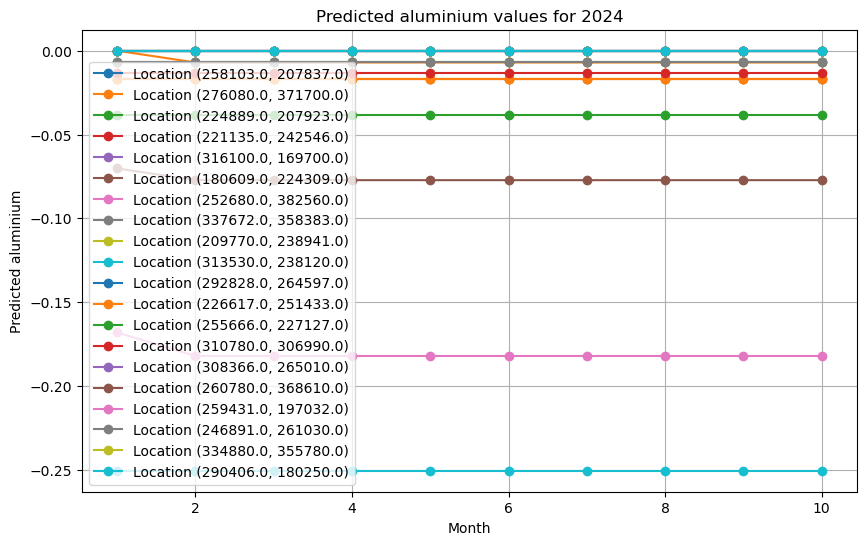

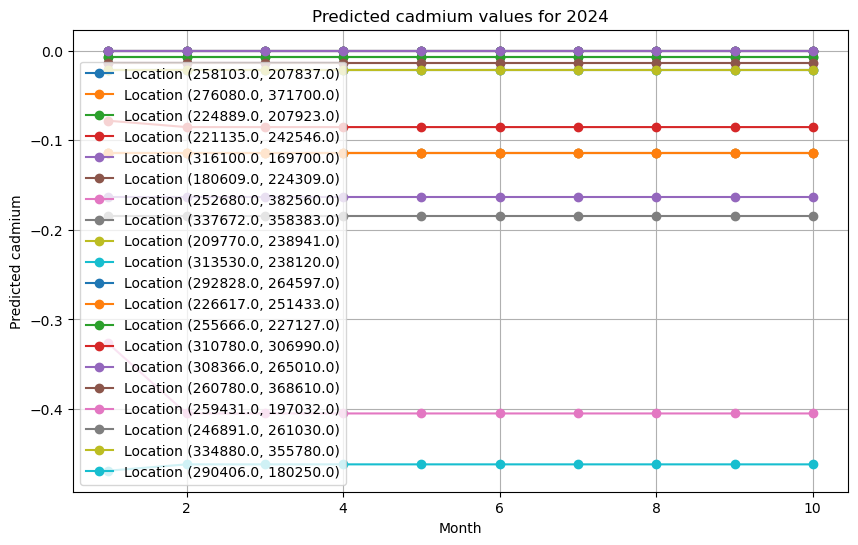

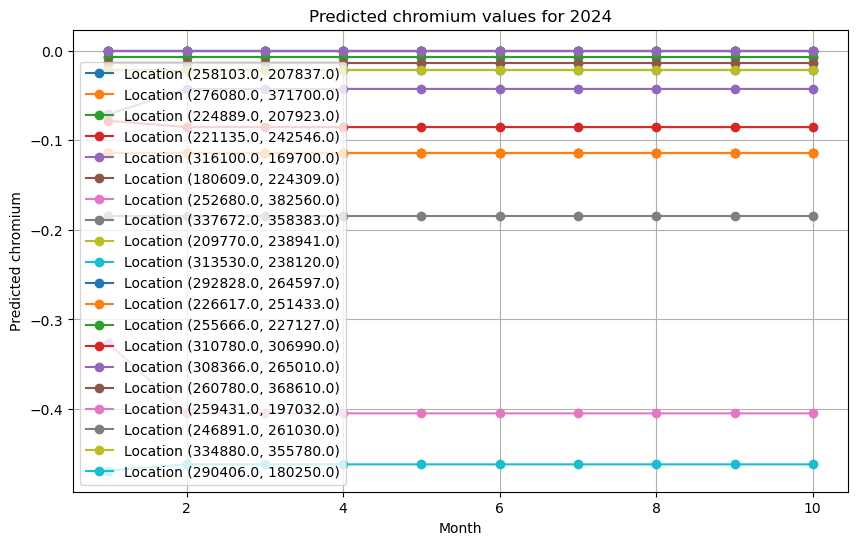

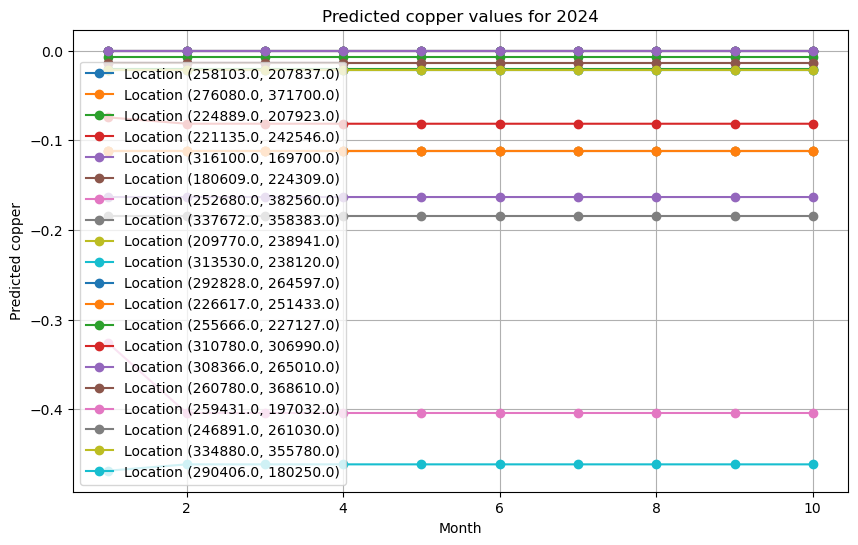

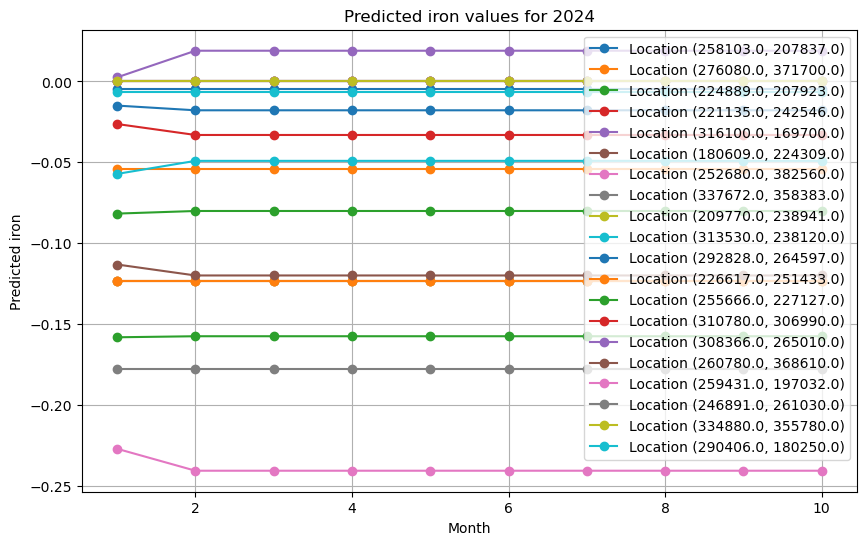

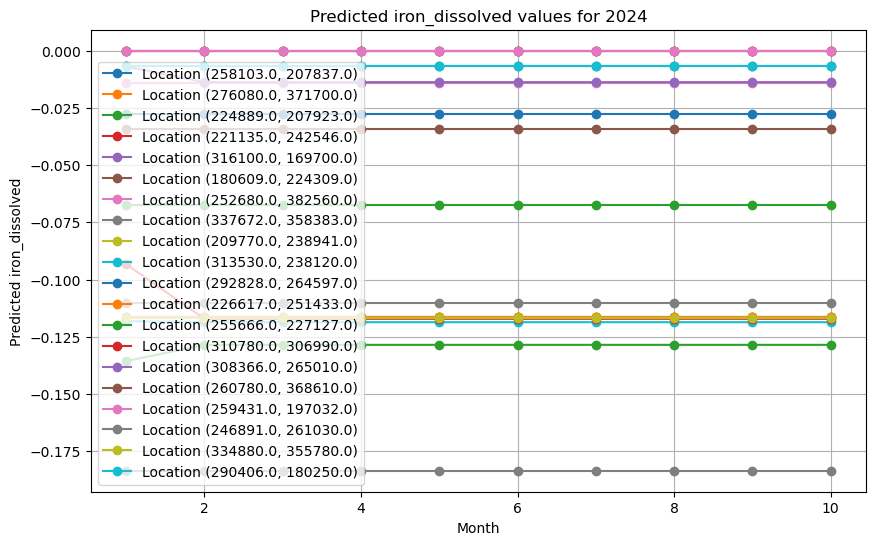

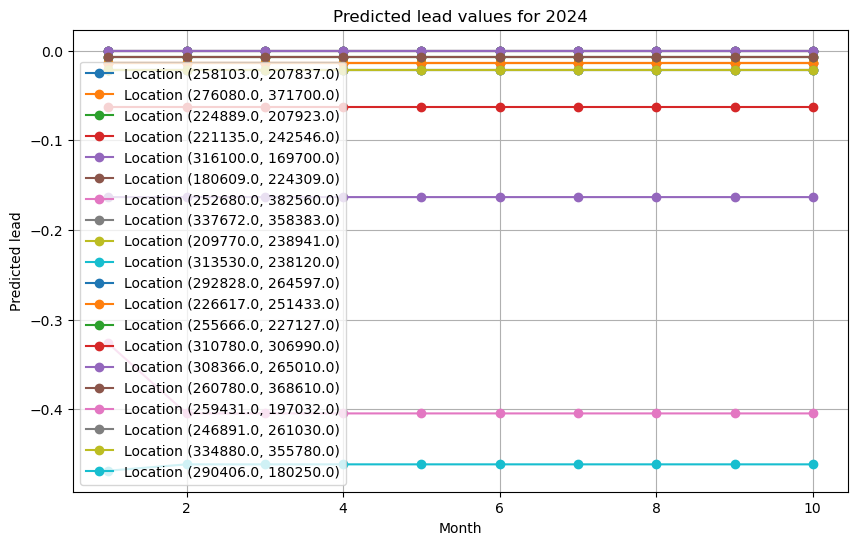

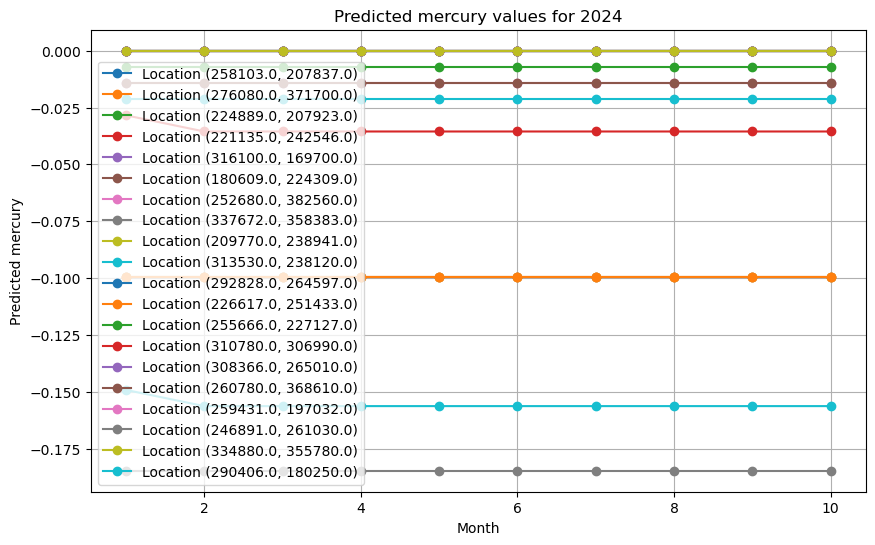

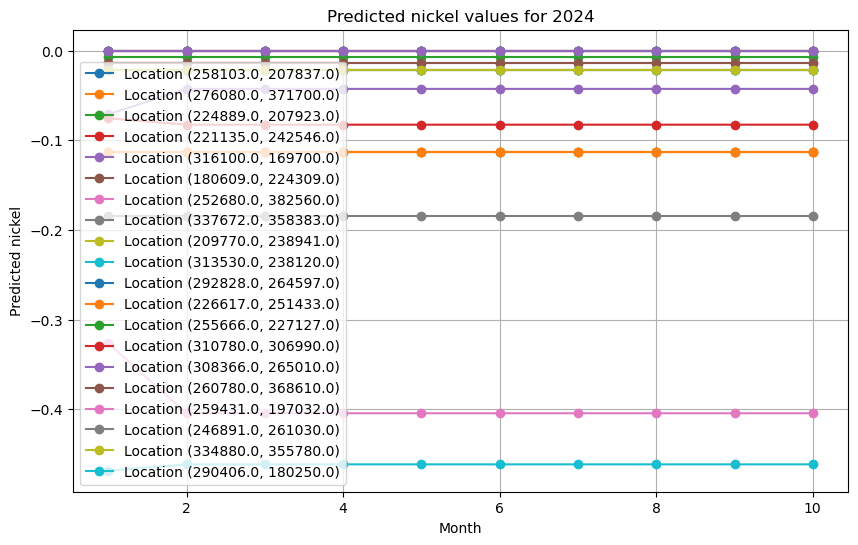

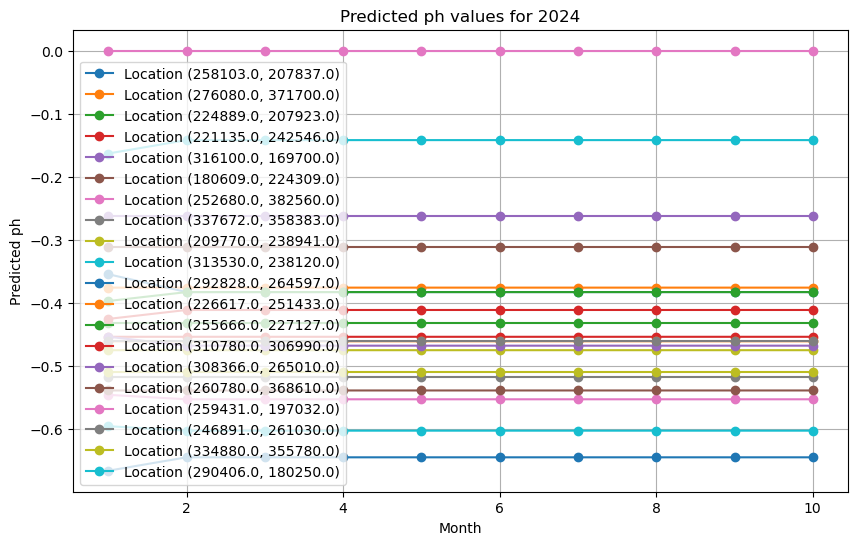

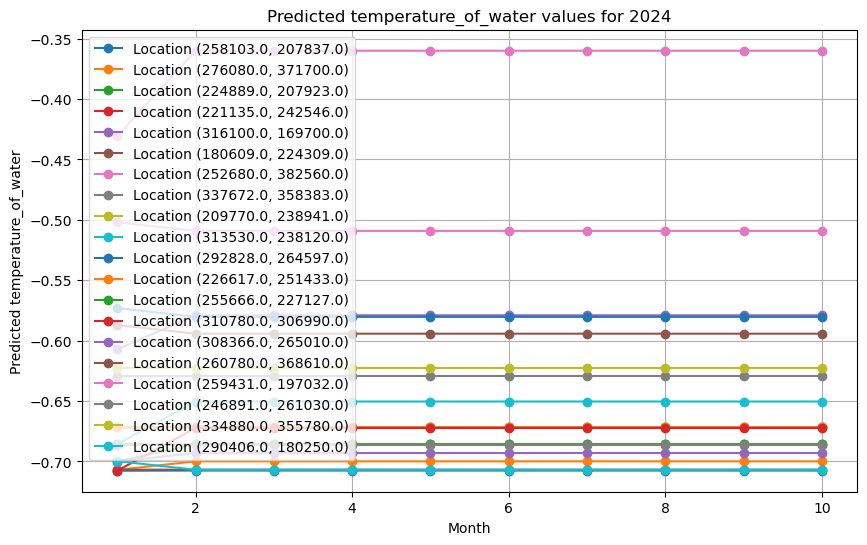

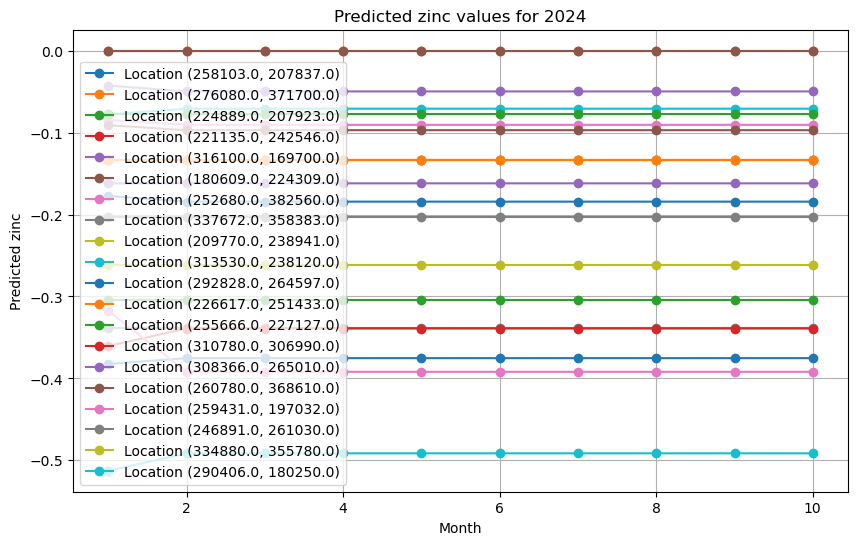

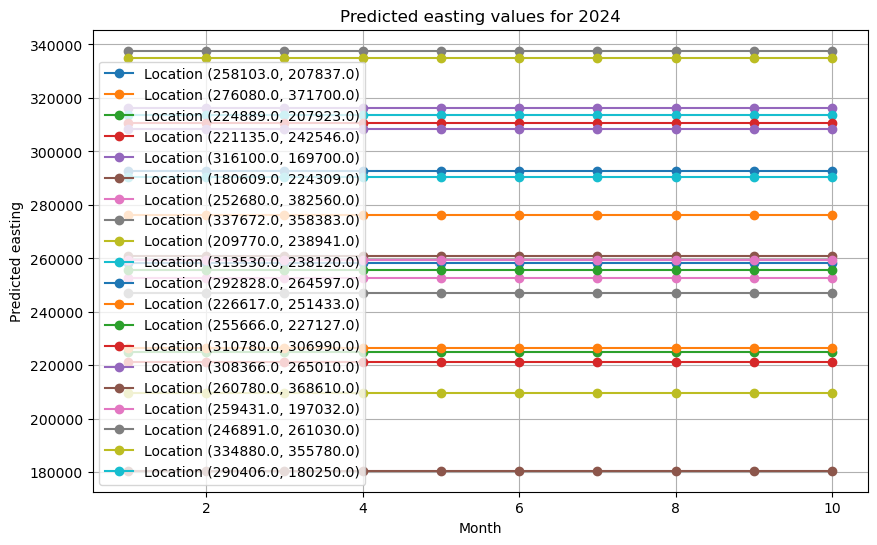

In [44]:
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the previously trained Random Forest model
rf_model = joblib.load('random_forest_model.pkl')

# Define the selected locations (easting, northing pairs)
easting_values = [258103.0, 276080.0, 224889.0, 221135.0, 316100.0, 180609.0, 
                  252680.0, 337672.0, 209770.0, 313530.0, 292828.0, 226617.0, 
                  255666.0, 310780.0, 308366.0, 260780.0, 259431.0, 246891.0, 
                  334880.0, 290406.0]

northing_values = [207837.0, 371700.0, 207923.0, 242546.0, 169700.0, 224309.0, 
                   382560.0, 358383.0, 238941.0, 238120.0, 264597.0, 251433.0, 
                   227127.0, 306990.0, 265010.0, 368610.0, 197032.0, 261030.0, 
                   355780.0, 180250.0]

# Standardize the easting and northing using the same scaler from the training
scaler = StandardScaler()
locations = np.array(list(zip(easting_values, northing_values)))
standardized_locations = scaler.fit_transform(locations)

# Prepare the data for prediction (2024, 10 months)
future_data = []

# Construct feature vectors for each of the 20 locations for the first 10 months of 2024
for loc in standardized_locations:
    for month in range(1, 11):  # Create the data for the first 10 months of 2024
        sequence = list(loc) + [2024, month, 10]  # Base sequence: location, year, month, day
        full_sequence = sequence * 10  # Repeat this sequence to reach 50 features
        future_data.append(full_sequence[:50])  # Ensure the sequence has exactly 50 features

X_rf = np.array(future_data)
print("Shape of X_rf for prediction:", X_rf.shape)  # Should be (200, 50) for 20 locations * 10 months

# Ensure that X_rf has the correct shape
if X_rf.shape[1] != 50:
    raise ValueError(f"X_rf should have 50 features, but got {X_rf.shape[1]} features.")

# Make predictions for the first 10 months of 2024
predictions_rf = rf_model.predict(X_rf)

# Prepare the output DataFrame
predictions_df = pd.DataFrame(predictions_rf, columns=[
    'aluminium', 'cadmium', 'chromium', 'copper', 'iron', 
    'iron_dissolved', 'lead', 'mercury', 'nickel', 
    'ph', 'temperature_of_water', 'zinc'])

# Expand the easting, northing, month, and day columns
predictions_df['easting'] = np.repeat(easting_values, 10)
predictions_df['northing'] = np.repeat(northing_values, 10)
predictions_df['year'] = 2024
predictions_df['month'] = np.tile(np.arange(1, 11), len(easting_values))
predictions_df['day'] = 10

# Save to CSV
predictions_df.to_csv('predicted_water_quality_2024.csv', index=False)
print("Predictions saved to 'predicted_water_quality_2024.csv'")

# Plotting the results
for param in predictions_df.columns[:-4]:  # Exclude easting, northing, year, month, and day from plotting
    plt.figure(figsize=(10, 6))
    for easting, northing in zip(easting_values, northing_values):
        loc_data = predictions_df[(predictions_df['easting'] == easting) & 
                                  (predictions_df['northing'] == northing)]
        plt.plot(loc_data['month'], loc_data[param], marker='o', label=f'Location ({easting}, {northing})')
    plt.title(f'Predicted {param} values for 2024')
    plt.xlabel('Month')
    plt.ylabel(f'Predicted {param}')
    plt.legend()
    plt.grid(True)
    plt.show()





In [46]:
import pandas as pd

# Load the original dataset
file_path = 'Restored_Sample_Values.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
print(data.head())

# Define the selected locations (easting, northing pairs)
easting_values = [258103.0, 276080.0, 224889.0, 221135.0, 316100.0, 180609.0, 
                  252680.0, 337672.0, 209770.0, 313530.0, 292828.0, 226617.0, 
                  255666.0, 310780.0, 308366.0, 260780.0, 259431.0, 246891.0, 
                  334880.0, 290406.0]

northing_values = [207837.0, 371700.0, 207923.0, 242546.0, 169700.0, 224309.0, 
                   382560.0, 358383.0, 238941.0, 238120.0, 264597.0, 251433.0, 
                   227127.0, 306990.0, 265010.0, 368610.0, 197032.0, 261030.0, 
                   355780.0, 180250.0]

# Create a DataFrame with the 20 selected locations
locations_df = pd.DataFrame({
    'easting': easting_values,
    'northing': northing_values
})

# Merge the original data with the locations to find the corresponding station types
# Assuming 'station_type' is the column that contains the station type information
station_types = pd.merge(locations_df, data[['easting', 'northing', 'station_type']], on=['easting', 'northing'], how='left')

# Drop duplicates to ensure each location is only represented once
station_types = station_types.drop_duplicates()

# Display the result
print(station_types)

# Save the results if needed
station_types.to_csv('selected_locations_station_types.csv', index=False)
print("Station types saved to 'selected_locations_station_types.csv'")


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_12376\1236389974.py:5: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


    easting  northing  parameter_shortname  sample_value_x  sampling_year  \
0  323449.0  307269.0                108.0       -0.039357         2000.0   
1  323449.0  307269.0               3164.0       -0.039354         2000.0   
2  323449.0  307269.0                111.0       -0.026289         2000.0   
3  323449.0  307269.0                135.0        0.033653         2000.0   
4  323449.0  307269.0               6452.0       -0.039187         2000.0   

  station_number                                       station_type  \
0      S00062260  SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...   
1      S00062260  SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...   
2      S00062260  SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...   
3      S00062260  SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...   
4      S00062260  SEWAGE DISCHARGES - FINAL/TREATED EFFLUENT - W...   

     sampling_datetime              parameter_name            unit_name  year  \
0  2000-01-14 12:15:00       

In [52]:
# Define the number of time steps (n) you want to use to predict the future
n_steps = 10  # You can adjust this value based on your needs

# Convert the data to numpy arrays
temporal_data = X[time_columns].values  # Temporal features (year, month, day)
spatial_data = X[geospatial_columns].values  # Spatial features (easting, northing)
y_array = y.values  # Target variables

# Determine the number of total samples
total_samples = temporal_data.shape[0] - n_steps

# Preallocate arrays for efficiency
X_seq_temporal = np.zeros((total_samples, n_steps, temporal_data.shape[1]))
X_seq_spatial = np.zeros((total_samples, n_steps, spatial_data.shape[1]))
y_seq = np.zeros((total_samples, y_array.shape[1]))

# Populate the arrays with sequences
for i in range(total_samples):
    X_seq_temporal[i] = temporal_data[i:i+n_steps]  # Temporal sequence
    X_seq_spatial[i] = np.tile(spatial_data[i], (n_steps, 1))  # Repeat spatial data across the sequence
    y_seq[i] = y_array[i + n_steps]  # Predict the target at the end of the sequence

# Split the data into training and validation sets
X_train_temporal, X_val_temporal, X_train_spatial, X_val_spatial, y_train, y_val = train_test_split(
    X_seq_temporal, X_seq_spatial, y_seq, test_size=0.2, random_state=42
)

# Print the shapes of the training and validation sets
print(f"Training set X_temporal: {X_train_temporal.shape}, X_spatial: {X_train_spatial.shape}, y: {y_train.shape}")
print(f"Validation set X_temporal: {X_val_temporal.shape}, X_spatial: {X_val_spatial.shape}, y: {y_val.shape}")



Training set X_temporal: (226539, 10, 3), X_spatial: (226539, 10, 2), y: (226539, 12)
Validation set X_temporal: (56635, 10, 3), X_spatial: (56635, 10, 2), y: (56635, 12)


Epoch 1/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - loss: 0.0509 - val_loss: 0.0430
Epoch 2/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0429 - val_loss: 0.0423
Epoch 3/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0413 - val_loss: 0.0405
Epoch 4/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0404 - val_loss: 0.0395
Epoch 5/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0395 - val_loss: 0.0395
Epoch 6/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0388 - val_loss: 0.0388
Epoch 7/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 71s 10ms/step - loss: 0.0385 - val_loss: 0.0386
Epoch 8/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0382 - val_loss: 0.0382
Epoch 9/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0380 - val_loss: 0.0389
Epoch 10/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - loss: 0.0377 - val_loss: 0.0383
Epoch 11/20
7080/7080 ━━━━━━━━━━━━━━━━━━━━ 71s 10ms/step - loss: 0.0375 - val_loss: 0.0376
Epoch 12

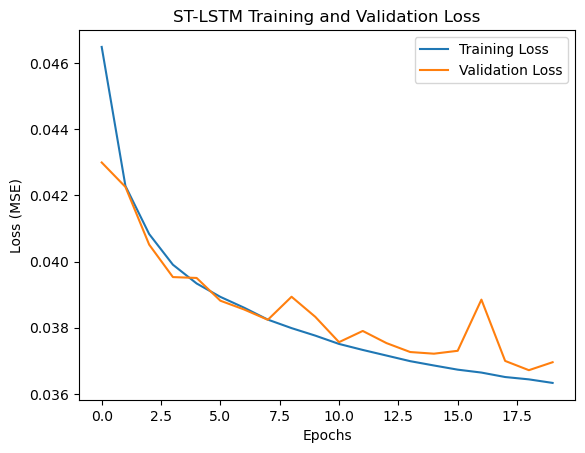

In [57]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Attention, Reshape, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


# Inputs for temporal and spatial data
temporal_input = Input(shape=(X_train_temporal.shape[1], X_train_temporal.shape[2]), name='Temporal_Input')
spatial_input = Input(shape=(X_train_spatial.shape[1], X_train_spatial.shape[2]), name='Spatial_Input')

# LSTM layer for temporal data
lstm_out = LSTM(50, activation='relu', return_sequences=True)(temporal_input)

# Spatial attention mechanism (optional)
spatial_reshaped = Reshape((1, -1))(spatial_input)  # Reshape spatial data to align with LSTM output
attention = Attention()([lstm_out, spatial_reshaped])

# Concatenate spatial data with the LSTM output after the LSTM layer
combined = Concatenate()([lstm_out, spatial_input])

# Flatten the combined output if necessary
flattened = tf.keras.layers.Flatten()(combined)

# Dense layer for the final output
output = Dense(y_train.shape[1], activation='linear')(flattened)


# Build the ST-LSTM model
st_lstm_model = Model(inputs=[temporal_input, spatial_input], outputs=output)
st_lstm_model.compile(optimizer='adam', loss='mse')

# Train the ST-LSTM model
st_lstm_history = st_lstm_model.fit(
    [X_train_temporal, X_train_spatial], y_train,
    validation_data=([X_val_temporal, X_val_spatial], y_val),
    epochs=20,  # You can adjust the number of epochs
    batch_size=32,  # You can adjust the batch size
    verbose=1
)
# Extract and print the final validation loss
st_lstm_validation_loss = st_lstm_history.history['val_loss'][-1]
print(f"Final ST-LSTM Validation Loss: {st_lstm_validation_loss:.4f}")

# Plot the training history for loss and validation loss
import matplotlib.pyplot as plt

plt.plot(st_lstm_history.history['loss'], label='Training Loss')
plt.plot(st_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('ST-LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


LSTM Validation Loss: 0.0134
GRU Validation Loss: 0.0167
Random Forest Validation MSE: 0.0054
XGBoost Validation MSE: 0.0100
ST-LSTM Validation MSE: 0.0370


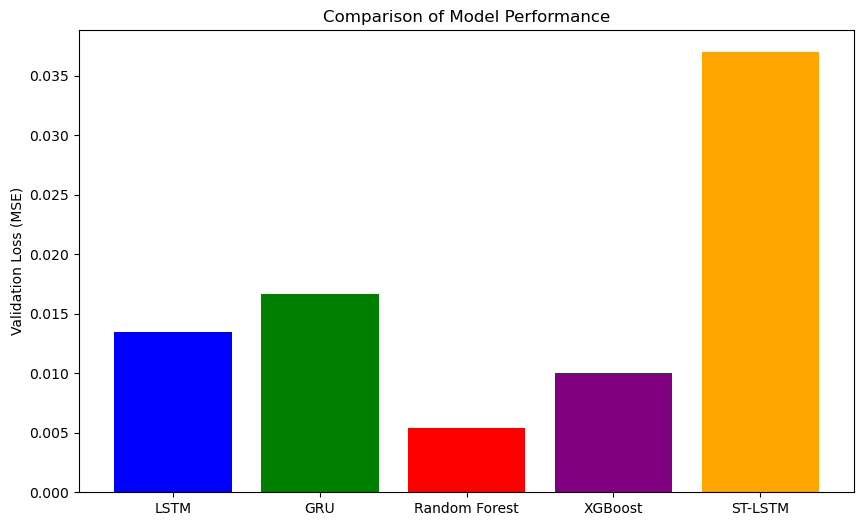

The best model is: Random Forest with a Validation Loss of: 0.0054


In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Set the ST-LSTM validation loss manually 
st_lstm_val_loss = st_lstm_validation_loss  # Assign the actual ST-LSTM validation loss value

# Print the validation losses (MSE) for each model
print(f"LSTM Validation Loss: {history_lstm.history['val_loss'][-1]:.4f}")
print(f"GRU Validation Loss: {history_gru.history['val_loss'][-1]:.4f}")
print(f"Random Forest Validation MSE: {rf_val_mse:.4f}")
print(f"XGBoost Validation MSE: {xgb_val_mse:.4f}")
print(f"ST-LSTM Validation MSE: {st_lstm_val_loss:.4f}")

# List of models and their corresponding validation losses for comparison
models = ['LSTM', 'GRU', 'Random Forest', 'XGBoost', 'ST-LSTM']
val_losses = [
    history_lstm.history['val_loss'][-1],
    history_gru.history['val_loss'][-1],
    rf_val_mse,
    xgb_val_mse,
    st_lstm_val_loss
]

# Create a bar chart to visualize the validation losses of different models
plt.figure(figsize=(10, 6))
plt.bar(models, val_losses, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylabel('Validation Loss (MSE)')
plt.title('Comparison of Model Performance')
plt.show()

# Determine the model with the lowest validation loss
best_model_index = np.argmin(val_losses)
best_model_name = models[best_model_index]
best_val_loss = val_losses[best_model_index]

# Output the best-performing model and its validation loss
print(f"The best model is: {best_model_name} with a Validation Loss of: {best_val_loss:.4f}")



In [66]:
import pandas as pd

# Load the dataset
file_path = 'predicted_water_quality_2024.csv'
data = pd.read_csv(file_path)
original_row_count = len(data)
print(f"Original number of rows: {original_row_count}")
unique_data = data.drop_duplicates()
unique_row_count = len(unique_data)
print(f"Number of rows after removing duplicates: {unique_row_count}")




Original number of rows: 200
Number of rows after removing duplicates: 200


In [69]:
import pandas as pd

# Load the dataset
file_path = 'predicted_water_quality_2024.csv'
data = pd.read_csv(file_path)

# Display the column names
print("Column names:", data.columns.tolist())




Column names: ['aluminium', 'cadmium', 'chromium', 'copper', 'iron', 'iron_dissolved', 'lead', 'mercury', 'nickel', 'ph', 'temperature_of_water', 'zinc', 'easting', 'northing', 'year', 'month', 'day']


In [71]:
# Now that we have the column names, let's remove duplicates based on all columns
unique_data = data.drop_duplicates(subset=['aluminium', 'cadmium', 'chromium', 'copper', 'iron', 
                                           'iron_dissolved', 'lead', 'mercury', 'nickel', 'ph', 
                                           'temperature_of_water', 'zinc', 'easting', 'northing', 
                                           'year', 'month', 'day'])

# Check the number of rows after removing duplicates
unique_row_count = len(unique_data)

# Save the cleaned data to a new CSV file
cleaned_file_path = 'predicted_water_quality_2024_cleaned.csv'
unique_data.to_csv(cleaned_file_path, index=False)

unique_row_count, cleaned_file_path


(200, 'predicted_water_quality_2024_cleaned.csv')

In [73]:
import pandas as pd

# Load the original dataset
original_data_path = 'Restored_Sample_Values.csv'
original_data = pd.read_csv(original_data_path)

# Load the standardized (predicted) dataset
standardized_data_path = 'predicted_water_quality_2024_cleaned.csv'
standardized_data = pd.read_csv(standardized_data_path)


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_12376\1534464836.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  original_data = pd.read_csv(original_data_path)


In [ ]:
import pandas as pd

# Load the original dataset
original_data_path = 'Restored_Sample_Values.csv'
original_data = pd.read_csv(original_data_path)

# Load the standardized (predicted) dataset
standardized_data_path = 'predicted_water_quality_2024_cleaned.csv'
standardized_data = pd.read_csv(standardized_data_path)

# Specify the relevant water quality parameters
parameters = ['aluminium', 'cadmium', 'chromium', 'copper', 'iron',
              'iron_dissolved', 'lead', 'mercury', 'nickel', 'ph',
              'temperature_of_water', 'zinc']

# Calculate mean and standard deviation for each parameter across all years and months
mean_values = original_data.groupby(['year', 'month'])[parameters].mean().mean(axis=0)
std_dev_values = original_data.groupby(['year', 'month'])[parameters].std().mean(axis=0)

# Inverse transform the standardized values in the predicted dataset
for param in parameters:
    standardized_data[param] = standardized_data[param] * std_dev_values[param] + mean_values[param]

# Save the restored data
restored_file_path = 'predicted_water_quality_2024_restored.csv'
standardized_data.to_csv(restored_file_path, index=False)

print("Inverse transformation completed and data saved to:", restored_file_path)



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the restored (predicted) dataset
restored_data_path = 'predicted_water_quality_2024_restored.csv'
restored_data = pd.read_csv(restored_data_path)

# Load the original dataset
original_data_path = 'Restored_Sample_Values.csv'
original_data = pd.read_csv(original_data_path)

# Identify the first station
first_station = restored_data.iloc[0]
easting, northing = first_station['easting'], first_station['northing']

# Filter original data for the first station's location and the year 2023, months 1-10
original_station_data = original_data[
    (original_data['easting'] == easting) &
    (original_data['northing'] == northing) &
    (original_data['year'] == 2023) &
    (original_data['month'].between(1, 10))
]

# Relevant parameters to compare
parameters = ['aluminium', 'cadmium', 'chromium', 'copper', 'iron',
              'iron_dissolved', 'lead', 'mercury', 'nickel', 'ph',
              'temperature_of_water', 'zinc']

# Extract the predicted values for the first station for months 1-10
predicted_values = restored_data.iloc[0:10][parameters]

# Extract the actual values from the original dataset
actual_values = original_station_data[parameters]

# Plotting the comparison
plt.figure(figsize=(15, 10))

for i, param in enumerate(parameters):
    plt.subplot(4, 3, i+1)
    plt.plot(range(1, 11), actual_values[param], label='Actual', marker='o')
    plt.plot(range(1, 11), predicted_values[param], label='Predicted', marker='x')
    plt.title(param)
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()
